In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import string
import itertools
import re

from wordcloud import WordCloud

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
from tensorflow.keras.losses import Hinge
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

Step 1: Load data set


In [10]:
data = pd.read_csv('tweets.csv',encoding='latin', header=None)
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
data.head(5)

sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

           user_id                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [11]:
sentiment_counts = data.sentiment.value_counts()
print(sentiment_counts)

0    800000
4    800000
Name: sentiment, dtype: int64


In [12]:
text_counts = data.text.value_counts()
print(text_counts)

isPlayer Has Died! Sorry                                                                              210
good morning                                                                                          118
headache                                                                                              115
Good morning                                                                                          112
Headache                                                                                              106
                                                                                                     ... 
braces  tell me it will be okay...                                                                      1
is stuck at home without curry                                                                          1
@mrsduryee I've applied to about 70 since I lost my job in March...it certainly FEELS like a lot!       1
The cheese I got @SarawithanR lost its squeak 

In [13]:
data.describe()

sentiment            id
count  1.600000e+06  1.600000e+06
mean   2.000000e+00  1.998818e+09
std    2.000001e+00  1.935761e+08
min    0.000000e+00  1.467810e+09
25%    0.000000e+00  1.956916e+09
50%    2.000000e+00  2.002102e+09
75%    4.000000e+00  2.177059e+09
max    4.000000e+00  2.329206e+09

<AxesSubplot:>

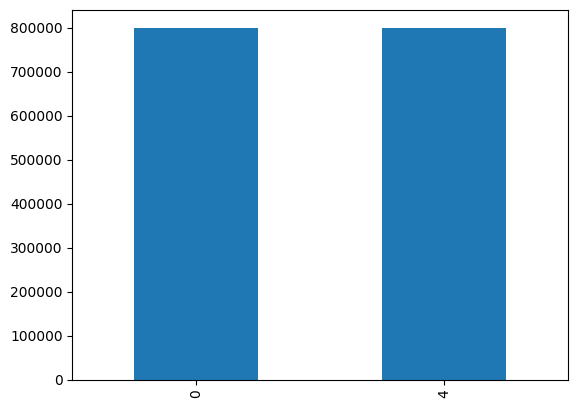

In [14]:
data['sentiment'].value_counts().plot(kind='bar')

<AxesSubplot:ylabel='sentiment'>

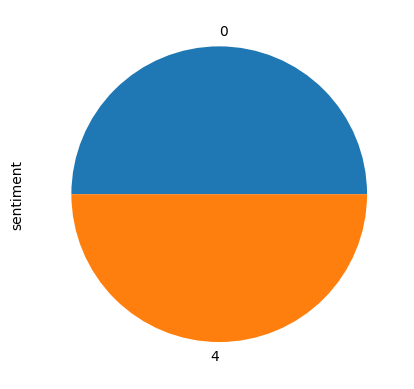

In [15]:
data['sentiment'].value_counts().plot(kind='pie')

Dropping useless info


In [16]:
data = data.drop(['id', 'date', 'query', 'user_id'], axis=1)

encoded_data = data

Assigning lable numbers with positive and neagtive traits


In [17]:
labels_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
    return labels_to_sentiment[label]
    encoded_data.sentiment = encoded_data.sentiment.apply(lambda x: label_decoder(x))
encoded_data.head(5)

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

Text(0.5, 1.0, '1.6 Million Twitter Tweets Sentiment Data Distribution')

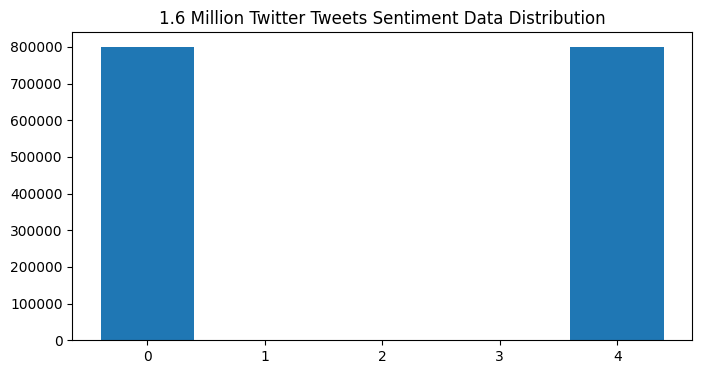

In [18]:
val_count = encoded_data.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("1.6 Million Twitter Tweets Sentiment Data Distribution")

Reducing data set


In [19]:
reduced_data = encoded_data
reduced_data.head(5)

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

Separating postive and negative rows

In [22]:
data_positive = reduced_data[reduced_data['sentiment'] == 4]
data_negative = reduced_data[reduced_data['sentiment'] == 0]
print(len(data_positive), len(data_negative))

800000 800000


In [23]:
cleaned_data = reduced_data
cleaned_data.head(5)

sentiment                                               text
0          0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  is upset that he can't update his Facebook by ...
2          0  @Kenichan I dived many times for the ball. Man...
3          0    my whole body feels itchy and like its on fire 
4          0  @nationwideclass no, it's not behaving at all....

Word clouds 1.Positive 2.Negative

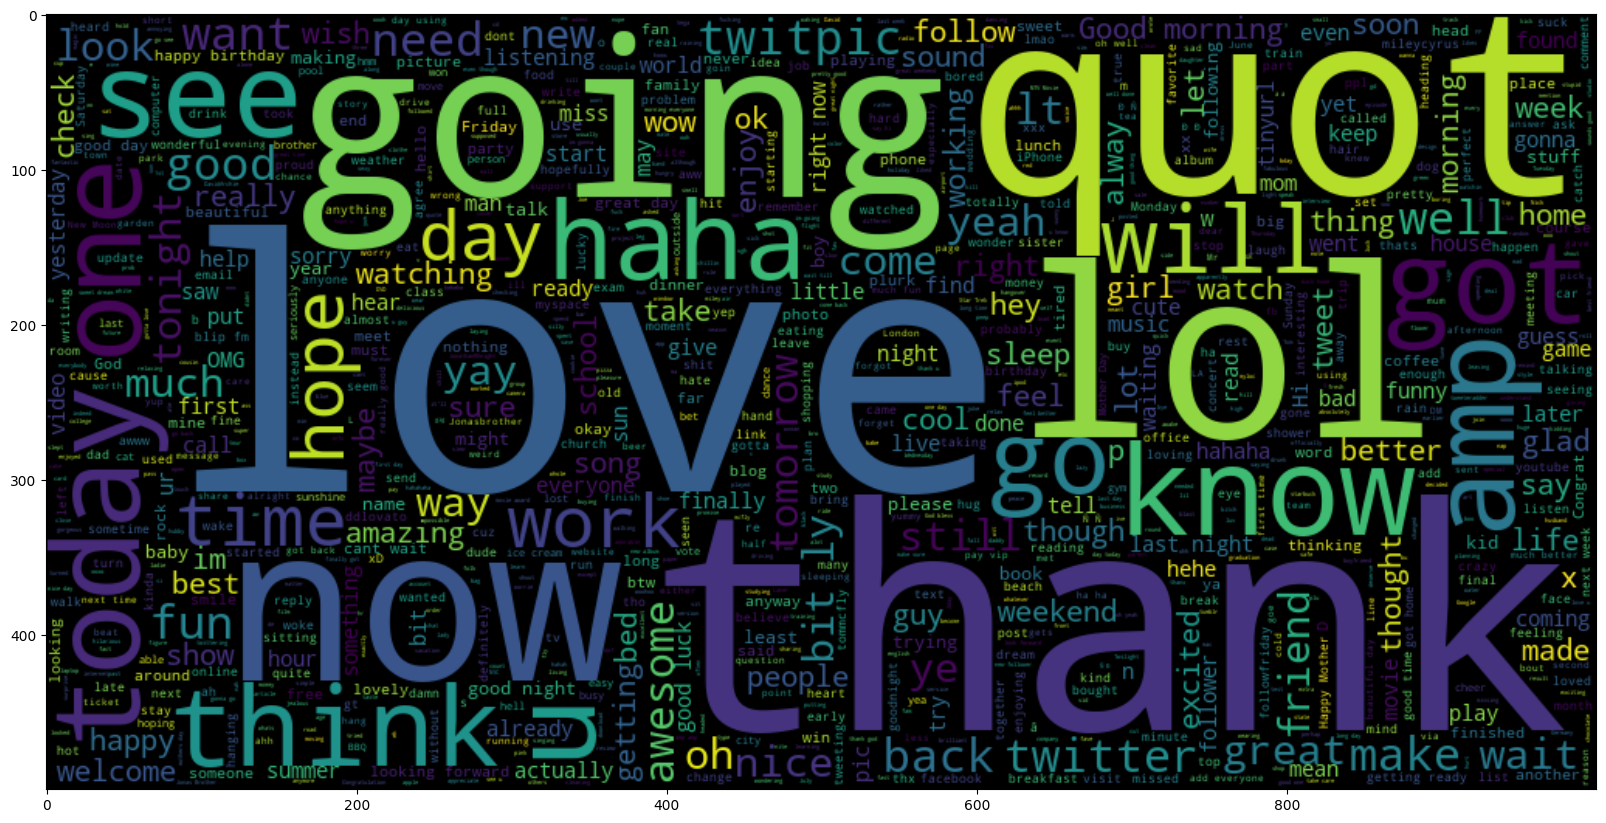

In [24]:
#Positve
plt.figure(figsize = (20,20)) 
Positive_WC = WordCloud(max_words = 1000 , width = 1000 , height = 500).generate(" ".join(cleaned_data[cleaned_data.sentiment == 4].text))
plt.imshow(Positive_WC , interpolation = 'bilinear')

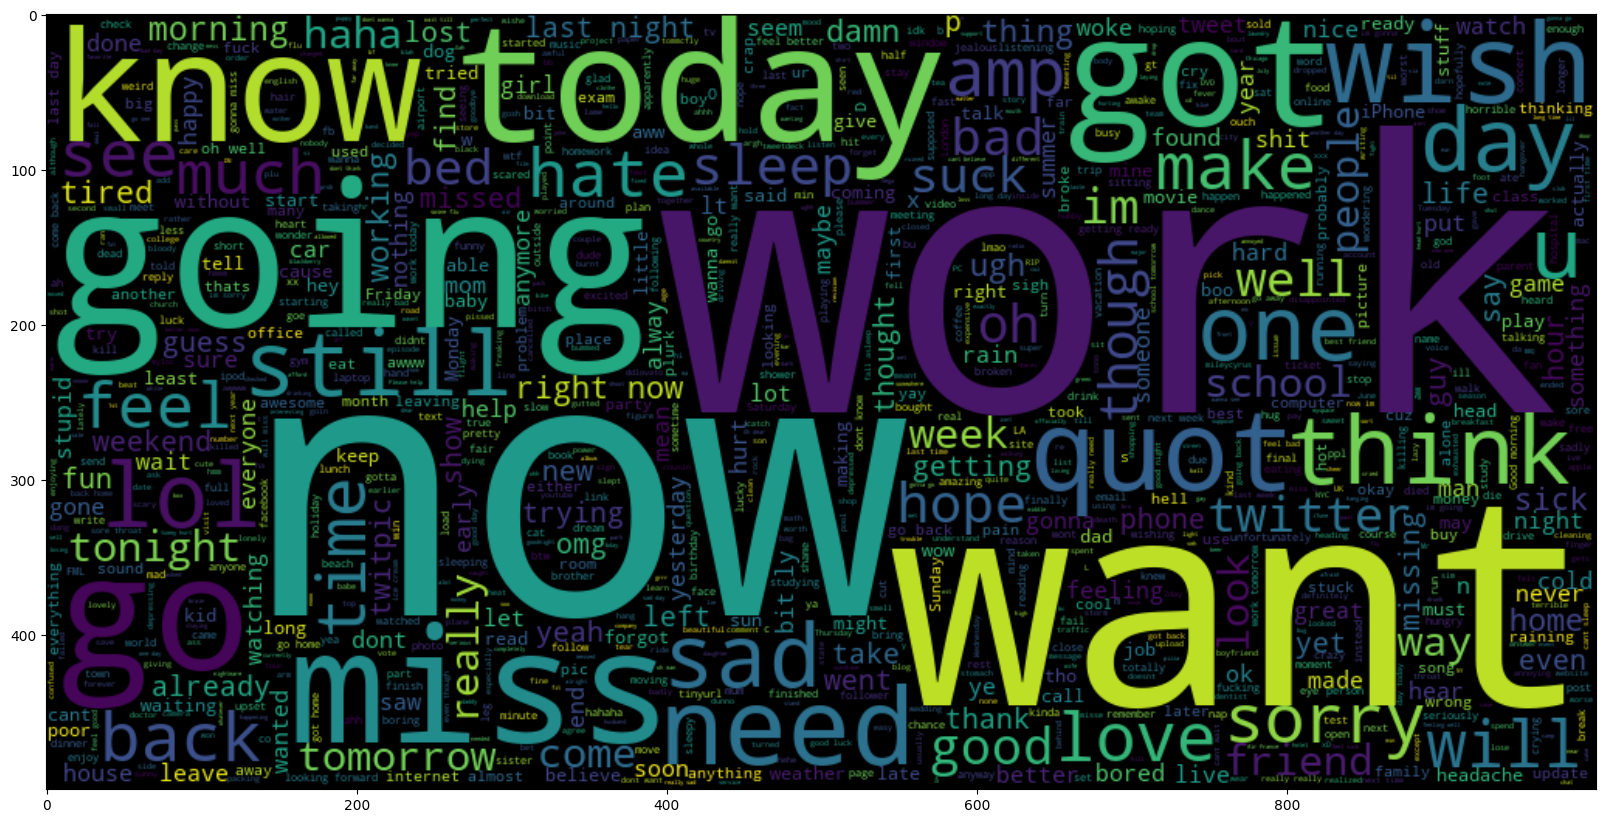

In [25]:
#Negative
plt.figure(figsize = (20,20)) 
Negative_WC = WordCloud(max_words = 1000 , width = 1000 , height = 500).generate(" ".join(cleaned_data[cleaned_data.sentiment == 0].text))
plt.imshow(Negative_WC , interpolation = 'bilinear')

Step 2: Text preprocessing

Removing URL fro the data

In [27]:
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

Clearing unnecessary texts

In [28]:
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"    

def text_cleaning(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    return text

removing numbers, emojis punctuations

In [29]:
def number_cleaning(text):
    text = ''.join(c for c in text if not c.isdigit())
    return text

def remove_emoji(string):
    emoji_pattern = re.compile(
    "["
        u"\U0001F600-\U0001F64F" #emoticons
        u"\U0001F300-\U0001F5FF" #symbols & pictographs
        u"\U0001F680-\U0001F6FF" #transport & map symbols
        u"\U0001F1E0-\U0001F1FF" #FLAGS on (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

def remove_punctuation(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

Stemming the text using the porter version and removing stopwords

In [30]:
def stemming_words(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    
    return " ".join(text)

Applying text preprocessing

In [31]:
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_URL(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_html(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: text_cleaning(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: number_cleaning(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_emoji(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: remove_punctuation(x))
cleaned_data["text"] = cleaned_data.text.apply(lambda x: stemming_words(x))
cleaned_data["text"] = cleaned_data["text"].apply(remove_stopwords)

In [32]:
cleaned_data

sentiment                                               text
0                0       awww bummer shoulda got david carr third day
1                0  upset updat hi facebook text might cri result ...
2                0       dive mani time ball manag save rest go bound
3                0                    whole bodi feel itchi like fire
4                0                           behav mad whi becaus see
...            ...                                                ...
1599995          4                         woke school best feel ever
1599996          4       thewdb com veri cool hear old walt interview
1599997          4                       readi mojo makeov ask detail
1599998          4  happi th birthday boo alll time tupac amaru sh...
1599999          4  happi charitytuesday thenspcc sparkschar speak...

[1600000 rows x 2 columns]

In [33]:
cleaned_data.text

0               awww bummer shoulda got david carr third day
1          upset updat hi facebook text might cri result ...
2               dive mani time ball manag save rest go bound
3                            whole bodi feel itchi like fire
4                                   behav mad whi becaus see
                                 ...                        
1599995                           woke school best feel ever
1599996         thewdb com veri cool hear old walt interview
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: text, Length: 1600000, dtype: object

Step 3: Splitting Data set

In [34]:
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=7) 

print("Train data size:", len(train_data))
print("Test data size", len(test_data))

Train data size: 1280000
Test data size 320000


Step 4: Tokenization

Settings for hyper parameters

In [40]:
vocabulary_size = 100000
max_word_length = 280
oov_tk = "<OOV>"
trunc_type='post'
padding_type='post'

Tokenizing

In [41]:
tokenizer = Tokenizer(num_words = vocabulary_size, oov_token = oov_tk)
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size :", vocab_size)

Vocabulary size : 232710


Sequences

In [42]:
train_sequences = tokenizer.texts_to_sequences(train_data.text) 
test_sequences = tokenizer.texts_to_sequences(test_data.text)

Padding to handle sentences with diffrent lengths

In [43]:
x_train = pad_sequences(train_sequences, maxlen=max_word_length, padding=padding_type, truncating=trunc_type)
x_test = pad_sequences(test_sequences, maxlen=max_word_length, padding=padding_type, truncating=trunc_type)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 280)
Testing X Shape: (320000, 280)


Step 5: Label Encoding

In [44]:
labels = train_data.sentiment.unique().tolist()

In [45]:
#Encoding sentiment lables
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



y_train shape: (1280000, 1)
y_test shape: (320000, 1)


Stage 6: Pretrained GloVe word embedding

loading the glove word embed

In [48]:
embeddings_index = {}

with open('./glove6b/glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [49]:
#Unique values
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 232709 unique tokens.


In [50]:
embeddings_index

{'the': array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
         1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
         2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
         1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
         2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
        -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
        -4.4640e-01,  1.7197e-01,  4.6246e-0

Creating the embedding matrix

In [52]:
num_words = len(word_index) + 1
embedding_dimension = 300

embedding_matrix = np.zeros((vocab_size, embedding_dimension))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [53]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0073678 ,  0.062532  , -0.097432  , ..., -0.32431999,
         0.19611   ,  0.29361999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Testing embedding index

In [54]:
word_index["good"]

7

In [55]:
embeddings_index.get("good")

array([-1.3602e-01, -1.1594e-01, -1.7078e-02, -2.9256e-01,  1.6149e-02,
        8.6472e-02,  1.5759e-03,  3.4395e-01,  2.1661e-01, -2.1366e+00,
        3.5278e-01, -2.3909e-01, -2.2174e-01,  3.6413e-01, -4.5021e-01,
        1.2104e-01, -1.5596e-01, -3.8906e-02, -2.9419e-03,  1.6009e-02,
       -1.1620e-01,  3.8680e-01,  3.5109e-01,  9.7426e-02, -1.2425e-02,
       -1.7864e-01, -2.3259e-01, -2.6960e-01,  4.1083e-02, -7.6194e-02,
       -2.3362e-01,  2.0919e-01, -2.7264e-01,  5.4967e-02, -1.8055e+00,
        5.6348e-01, -1.2778e-01,  2.3147e-01, -5.8820e-03, -2.6630e-01,
        4.1187e-01, -3.7162e-01, -2.0600e-01, -1.9619e-01, -4.3945e-03,
        1.2513e-01,  4.6638e-01,  4.5159e-01, -1.5000e-01,  5.9589e-03,
        5.9070e-02, -4.1440e-01,  6.1035e-02, -2.1117e-01, -4.0988e-01,
        5.6393e-01,  2.3021e-01,  2.7240e-01,  4.9364e-02,  1.4239e-01,
        4.1841e-01, -1.3983e-01,  3.4826e-01, -1.0745e-01, -2.5002e-01,
       -3.2554e-01,  3.3343e-01, -3.5617e-01,  2.0442e-01,  1.44

In [56]:
(embedding_matrix[7] == embeddings_index.get("good")).all()

True

Analysing the training and testing data sets

In [58]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test: ",x_test.shape)
print("y_test: ",y_test.shape)

x_train: (1280000, 280)
y_train: (1280000, 1)
x_test:  (320000, 280)
y_test:  (320000, 1)


Step 7: Traing the 4 RNN-SVM models

Training LSTM_SVM model

In [61]:
LSTM_SVM_model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dimension, 
                            weights=[embedding_matrix], 
                            input_length=max_word_length, 
                            trainable=False),
    
    tf.keras.layers.SpatialDropout1D(0.40),
    tf.keras.layers.LSTM((128), return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM((128)),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Activation('linear')
])

In [ ]:
LSTM_SVM_model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])